<a href="https://colab.research.google.com/github/sunilhucharaddi/fastai-v3/blob/master/lesson_3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Image segmentation with CamVid**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [43]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/content/data/camvid/valid.txt'),
 PosixPath('/content/data/camvid/codes.txt'),
 PosixPath('/content/data/camvid/labels'),
 PosixPath('/content/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [18]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

**DATA**

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_04560.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00330.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08117.png')]

In [12]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_05880_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03720_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05250_P.png')]

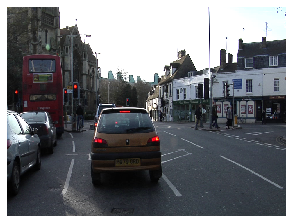

In [13]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5)

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

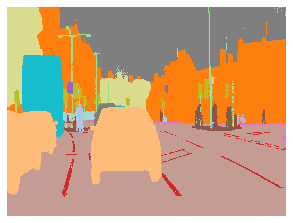

In [29]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [32]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [44]:
path

PosixPath('/content/data/camvid')

In [46]:
codes = np.loadtxt(path/'codes.txt',dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

**Datasets**

[following size had some issue](https://forums.fast.ai/t/error-in-lesson-3-camvid-with-colab/35329/12)

In [52]:


size = (src_size//2).tolist() []

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM freee")

using bs=8, have 15068MB of GPU RAM freee


In [0]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_fname_file('../valid.txt')
        .label_from_func(get_y_fn,classes=codes)) 

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

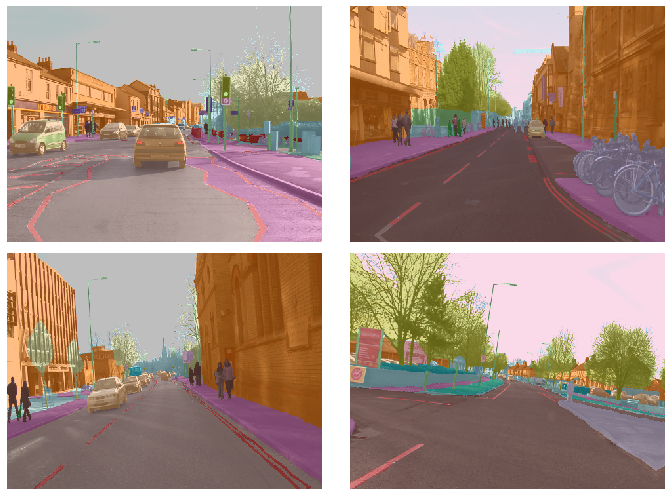

In [56]:
data.show_batch(2,figsize = (10,7))

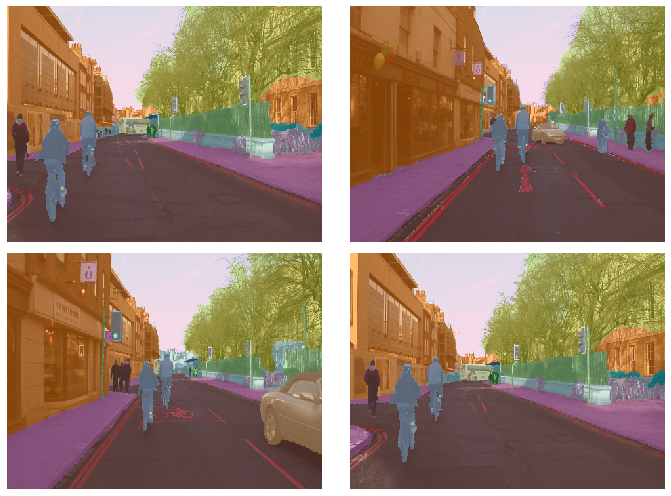

In [57]:
data.show_batch(2, figsize=(10,7),ds_type=DatasetType.Valid)

**Model**

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [64]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 42.2MB/s]


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


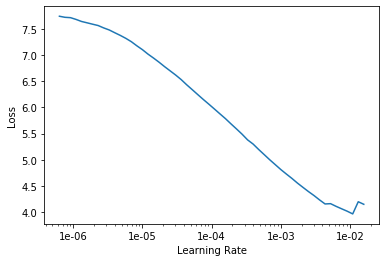

In [65]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 3e-3

In [69]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.466103,0.842309,0.803930,01:29
1,0.933981,0.849906,0.789787,01:25
2,0.760661,0.548547,0.852114,01:25
3,0.685633,0.540074,0.852119,01:25
4,0.634841,0.516430,0.860247,01:24
5,0.596351,0.453598,0.869033,01:24
6,0.572949,0.461784,0.876453,01:24
7,0.591370,0.529136,0.868640,01:24
8,0.543264,0.425275,0.876845,01:23
9,0.461120,0.350339,0.896393,01:23


In [0]:
learn.save('stage-1')
learn.load('stage-1');

In [70]:
learn.show_results(rows=3, figsize =(8,9))

SyntaxError: ignored

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [73]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.398738,0.337931,0.897442,01:28
1,0.387410,0.333833,0.901151,01:27
2,0.384272,0.315520,0.911182,01:27
3,0.368092,0.321806,0.909145,01:27
4,0.354726,0.296728,0.917453,01:27
5,0.343300,0.286002,0.925337,01:27
6,0.333715,0.306474,0.918452,01:27
7,0.325070,0.311982,0.910174,01:27
8,0.312468,0.275606,0.927068,01:27
9,0.295068,0.273956,0.922887,01:27


In [0]:
learn.save('stage-2')

**GO BIG(train with full image size)**

you may need to restart kernel and come back to this stage 

In [75]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
#the max sixe of bs depends on the availble GPU RAM
if free > 8200: bs=3
else:            bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

SyntaxError: ignored

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [78]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


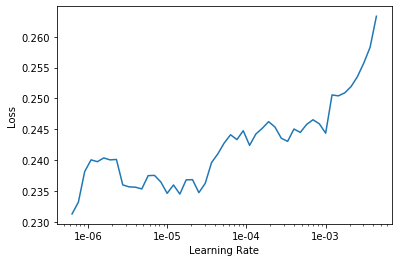

In [79]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.237942,0.257690,0.928165,01:24
1,0.239122,0.248754,0.929871,01:24
2,0.238475,0.256566,0.928217,01:24
3,0.244829,0.294864,0.914863,01:24
4,0.248612,0.279557,0.921116,01:24
5,0.257354,0.294864,0.918559,01:24
6,0.253956,0.311111,0.913297,01:24


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10,lrs)

In [0]:
learn.save('stage-2-big')
learn.load('stage-2-big')

In [0]:
learn.show_results(rows=3, figsize=(10,10))